In [1]:
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.saved_model import signature_constants
import tensorflow_addons as tfa
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time

tfa.register.register_all()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=768)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)
output_saved_model_dir = "./config/hfnet_v2" 
verify_images_path= "/ssd/drone_data_process/images"

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (400, 208))
        if img is not None:
            images.append(img)
    return images
images = load_images_from_folder(verify_images_path)
print(f"Load {len(images)} images")

1 Physical GPUs, 1 Logical GPUs
Load 5735 images


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
--- Loading Graph 13.001940488815308 seconds ---
First Try
--- First trial 16.260194540023804 seconds ---
--- Try 5735 images, average 49.26940981159027 ms ---


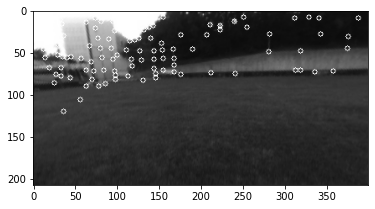

In [4]:
start_time = time.time()

def load():
    saved_model_loaded = tf.saved_model.load(
        output_saved_model_dir, tags=[tag_constants.SERVING])

    frozen_func = graph_func = saved_model_loaded.signatures[
       signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
    return frozen_func
def run(img):
    _img = np.expand_dims(img, axis=2)
    _img = np.array([_img]).astype(np.float)
    _img = tf.convert_to_tensor(_img, dtype=tf.float32)
    #print(_img.shape)
    output = frozen_func(_img)
    return output

def draw(img, ret):
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    kps = ret["keypoints"][0].numpy()
    for kp in kps:
        img = cv2.circle(img, (kp[0], kp[1]), 3, (255, 255, 255))
    plt.imshow(img)
    plt.show()

frozen_func = load()
print("--- Loading Graph %s seconds ---" % (time.time() - start_time))

print("First Try")
start_time = time.time()
ret = run(images[0])
print("--- First trial %s seconds ---" % (time.time() - start_time))

start_time = time.time()

for i in range(0, len(images)):
    _time = time.time()
    ret = run(images[i])
    if (time.time() - _time > 0.1):
        print(f"Img {i} cost {(time.time() - _time)*1000}ms")
        #draw(images[i], ret)
        
print(f"--- Try {len(images)} images, average {(time.time() - start_time)/len(images)*1000} ms ---")
        
ret = run(images[0])

img = cv2.cvtColor(images[0], cv2.COLOR_GRAY2RGB)
kps = ret["keypoints"][0].numpy()
for kp in kps:
    img = cv2.circle(img, (kp[0], kp[1]), 3, (255, 255, 255))
plt.imshow(img)

TensorShape([1, 98, 2])

In [8]:
ret = run(images[100])
ret["keypoints"].shape

TensorShape([1, 200, 2])